# 19. Matched Negative Validation

The retrain floor is 0.481, not 0.5. This means the attacker can still weakly distinguish forget-set members from matched negatives even after retraining without them. Two possible explanations:

1. The matched negatives (k-NN from unseen set in baseline latent space) do not fully control for biology. Megakaryocytes are rare, and the nearest unseen cells may still be from different cell types.
2. The attacker overfits to the small sample (30 forget vs 194 matched).

This notebook tests both by:
- **Within-cluster holdout negatives**: Use the 5 cluster-13 cells in the unseen set as negatives (maximally biology-matched, but small n).
- **Per-model matched negatives**: Recompute k-NN in each model's latent space (not just baseline) and compare AUC.

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

from vae import VAE, vae_loss
from attacker import MLPAttacker, extract_vae_features, build_attack_features
from train_attacker_conditioned import extract_features_for_split
from attacker_eval import matched_negative_evaluation, compute_attack_metrics

DATA_PATH = Path('../data/adata_processed.h5ad')
OUTPUTS_PATH = Path('../outputs')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256
print(f'Device: {DEVICE}')

2026-02-08 00:28:09.313779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Device: cpu


## 1. Load data and models

In [2]:
# Load data
adata = sc.read_h5ad(DATA_PATH)
leiden = adata.obs['leiden'].values
print(f"Data: {adata.shape}")

# Load structured split
with open(OUTPUTS_PATH / 'p1' / 'split_structured.json', 'r') as f:
    split = json.load(f)

forget_idx = np.array(split['forget_indices'])
retain_idx = np.array(split['retain_indices'])
unseen_idx = np.array(split['unseen_indices'])

# Load existing matched negatives
with open(OUTPUTS_PATH / 'p1.5' / 's1_matched_negatives.json', 'r') as f:
    matched_data = json.load(f)
baseline_matched_idx = np.array(matched_data['matched_indices'])

print(f"Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Unseen: {len(unseen_idx)}")
print(f"Baseline matched negatives: {len(baseline_matched_idx)} (k={matched_data['k']})")

# Cluster 13 breakdown
c13_in_unseen = unseen_idx[leiden[unseen_idx] == '13']
print(f"\nCluster 13 cells in unseen set: {len(c13_in_unseen)}")
print(f"Cluster 13 cells in forget set: {(leiden[forget_idx] == '13').sum()}")

# What clusters are the matched negatives from?
matched_clusters = leiden[baseline_matched_idx]
cluster_counts = dict(zip(*np.unique(matched_clusters, return_counts=True)))
print(f"\nMatched negative cluster composition:")
for c, n in sorted(cluster_counts.items(), key=lambda x: -x[1]):
    print(f"  Cluster {c}: {n} cells")

Data: (33088, 2000)
Forget: 30, Retain: 28094, Unseen: 4964
Baseline matched negatives: 194 (k=10)

Cluster 13 cells in unseen set: 5
Cluster 13 cells in forget set: 30

Matched negative cluster composition:
  Cluster 1: 39 cells
  Cluster 0: 38 cells
  Cluster 2: 35 cells
  Cluster 4: 34 cells
  Cluster 3: 13 cells
  Cluster 7: 6 cells
  Cluster 8: 6 cells
  Cluster 11: 5 cells
  Cluster 6: 5 cells
  Cluster 9: 5 cells
  Cluster 13: 3 cells
  Cluster 10: 2 cells
  Cluster 5: 2 cells
  Cluster 12: 1 cells


In [3]:
def load_vae(checkpoint_path: Path) -> VAE:
    """Load VAE from checkpoint."""
    model = VAE(
        input_dim=2000,
        latent_dim=32,
        hidden_dims=[1024, 512, 128],
        dropout=0.1,
        use_layer_norm=True
    )
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    model.train(False)
    return model

def get_latent_codes(model, adata, indices, device):
    """Extract latent mean codes for given indices."""
    X = adata.X[indices]
    if hasattr(X, 'toarray'):
        X = X.toarray()
    x = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        mu, _ = model.encode(x)
    return mu.cpu().numpy()

# Load models
model_paths = {
    'Baseline': OUTPUTS_PATH / 'p1' / 'baseline' / 'best_model.pt',
    'Retrain': OUTPUTS_PATH / 'p1' / 'retrain_structured' / 'best_model.pt',
    'Extra-grad': OUTPUTS_PATH / 'p2' / 'adversarial_sweep' / 'extragradient_lambda10_model.pt',
    'Fisher': OUTPUTS_PATH / 'p2' / 'fisher_v2_correct' / 'unlearned_model.pt',
}

models = {}
for name, path in model_paths.items():
    if path.exists():
        models[name] = load_vae(path)
        print(f"Loaded: {name}")
    else:
        print(f"Not found: {name} ({path})")

Loaded: Baseline
Loaded: Retrain
Loaded: Extra-grad
Loaded: Fisher


## 2. Within-cluster holdout negatives

Only 5 cluster-13 cells are in the unseen set. This is too few to train a robust attacker, but we can still compute the MLP attacker AUC to see if it moves closer to 0.5 when negatives come from the same cluster.

In [4]:
def train_and_eval_attacker(model, adata, forget_indices, neg_indices, device,
                            n_seeds=5, epochs=50, batch_size=256):
    """Train MLP attacker and return AUC across seeds.
    
    Uses stratified leave-one-out style: train on 80%, eval on full set.
    Multiple seeds to account for small-sample variance.
    """
    # Get reference latent codes for kNN features
    retain_z = get_latent_codes(model, adata, retain_idx[:5000], device)
    
    # Extract features
    forget_feats, forget_knn, _ = extract_features_for_split(
        model, adata, forget_indices, batch_size, device,
        reference_z_retain=retain_z
    )
    neg_feats, neg_knn, _ = extract_features_for_split(
        model, adata, neg_indices, batch_size, device,
        reference_z_retain=retain_z
    )
    
    forget_X = build_attack_features(forget_feats, forget_knn, None)
    neg_X = build_attack_features(neg_feats, neg_knn, None)
    feature_dim = forget_X.shape[1]
    
    # Labels
    all_X = torch.cat([forget_X, neg_X], dim=0)
    all_y = torch.cat([torch.ones(len(forget_X)), torch.zeros(len(neg_X))], dim=0)
    
    aucs = []
    for seed in range(n_seeds):
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        # Stratified split
        train_idx, test_idx = train_test_split(
            np.arange(len(all_X)), test_size=0.2,
            stratify=all_y.numpy(), random_state=seed
        )
        
        train_X, train_y = all_X[train_idx], all_y[train_idx]
        
        train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
        
        attacker = MLPAttacker(
            input_dim=feature_dim,
            hidden_dims=[256, 256],
            dropout=0.3,
            use_spectral_norm=True
        ).to(device)
        optimizer = torch.optim.Adam(attacker.parameters(), lr=1e-3)
        
        # Train
        for epoch in range(epochs):
            attacker.train(True)
            for bx, by in train_loader:
                bx, by = bx.to(device), by.to(device)
                logits = attacker(bx).squeeze()
                loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, by)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Evaluate on full set (not just test) for stable AUC with small n
        metrics = matched_negative_evaluation(attacker, forget_X, neg_X, device=device)
        aucs.append(metrics['auc'])
    
    return {
        'mean_auc': float(np.mean(aucs)),
        'std_auc': float(np.std(aucs)),
        'aucs': [float(a) for a in aucs],
        'advantage': float(2 * abs(np.mean(aucs) - 0.5)),
        'n_forget': len(forget_indices),
        'n_neg': len(neg_indices)
    }

In [5]:
# Test 1: Within-cluster negatives (5 cluster-13 unseen cells)
# vs Test 2: Original matched negatives (194 cells from mixed clusters)

print("=" * 70)
print("WITHIN-CLUSTER vs BASELINE MATCHED NEGATIVES")
print("=" * 70)

within_cluster_results = {}
baseline_matched_results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Within-cluster: 30 forget vs 5 same-cluster unseen
    print(f"  Within-cluster (30 vs 5)...")
    wc = train_and_eval_attacker(model, adata, forget_idx, c13_in_unseen, DEVICE)
    within_cluster_results[name] = wc
    print(f"    AUC: {wc['mean_auc']:.3f} +/- {wc['std_auc']:.3f} (advantage: {wc['advantage']:.3f})")
    
    # Original matched: 30 forget vs 194 mixed-cluster unseen
    print(f"  Baseline matched (30 vs {len(baseline_matched_idx)})...")
    bm = train_and_eval_attacker(model, adata, forget_idx, baseline_matched_idx, DEVICE)
    baseline_matched_results[name] = bm
    print(f"    AUC: {bm['mean_auc']:.3f} +/- {bm['std_auc']:.3f} (advantage: {bm['advantage']:.3f})")

WITHIN-CLUSTER vs BASELINE MATCHED NEGATIVES

--- Baseline ---
  Within-cluster (30 vs 5)...
    AUC: 0.527 +/- 0.000 (advantage: 0.053)
  Baseline matched (30 vs 194)...
    AUC: 0.775 +/- 0.008 (advantage: 0.550)

--- Retrain ---
  Within-cluster (30 vs 5)...
    AUC: 0.609 +/- 0.003 (advantage: 0.219)
  Baseline matched (30 vs 194)...
    AUC: 0.495 +/- 0.006 (advantage: 0.010)

--- Extra-grad ---
  Within-cluster (30 vs 5)...
    AUC: 0.463 +/- 0.003 (advantage: 0.075)
  Baseline matched (30 vs 194)...
    AUC: 0.503 +/- 0.000 (advantage: 0.007)

--- Fisher ---
  Within-cluster (30 vs 5)...
    AUC: 0.620 +/- 0.000 (advantage: 0.240)
  Baseline matched (30 vs 194)...
    AUC: 0.815 +/- 0.000 (advantage: 0.630)


In [6]:
# Summary table
print("\nComparison: within-cluster vs baseline matched negatives")
print("-" * 75)
print(f"{'Method':<15} {'Within-cluster AUC':>20} {'Matched AUC':>15} {'Delta':>10}")
print("-" * 75)

for name in models:
    wc_auc = within_cluster_results[name]['mean_auc']
    bm_auc = baseline_matched_results[name]['mean_auc']
    delta = wc_auc - bm_auc
    print(f"{name:<15} {wc_auc:>15.3f} +/- {within_cluster_results[name]['std_auc']:.3f}"
          f" {bm_auc:>10.3f} +/- {baseline_matched_results[name]['std_auc']:.3f}"
          f" {delta:>+10.3f}")


Comparison: within-cluster vs baseline matched negatives
---------------------------------------------------------------------------
Method            Within-cluster AUC     Matched AUC      Delta
---------------------------------------------------------------------------
Baseline                  0.527 +/- 0.000      0.775 +/- 0.008     -0.248
Retrain                   0.609 +/- 0.003      0.495 +/- 0.006     +0.114
Extra-grad                0.463 +/- 0.003      0.503 +/- 0.000     -0.041
Fisher                    0.620 +/- 0.000      0.815 +/- 0.000     -0.195


## 3. Per-model matched negatives

The original matched negatives were computed in the baseline model's latent space. After unlearning, the latent geometry changes. If forget-set cells move in latent space, the original matched negatives may no longer be the closest unseen cells. This section recomputes k-NN matching per model.

In [7]:
def compute_matched_negatives(model, adata, forget_indices, unseen_indices, device, k=10):
    """Compute k-NN matched negatives in a given model's latent space."""
    forget_z = get_latent_codes(model, adata, forget_indices, device)
    unseen_z = get_latent_codes(model, adata, unseen_indices, device)
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(unseen_z)
    distances, indices_knn = nbrs.kneighbors(forget_z)
    
    matched_local = np.unique(indices_knn.flatten())
    matched_global = unseen_indices[matched_local]
    
    return matched_global, float(distances.mean())

# Compute per-model matched negatives
per_model_matched = {}
for name, model in models.items():
    matched, mean_dist = compute_matched_negatives(
        model, adata, forget_idx, unseen_idx, DEVICE, k=10
    )
    per_model_matched[name] = matched
    
    # How much overlap with baseline matched negatives?
    overlap = len(set(matched) & set(baseline_matched_idx))
    
    # Cluster composition
    clusters = leiden[matched]
    cluster_counts = dict(zip(*np.unique(clusters, return_counts=True)))
    
    print(f"{name}: {len(matched)} matched, mean_dist={mean_dist:.3f}, "
          f"overlap with baseline={overlap}/{len(baseline_matched_idx)}, "
          f"clusters={cluster_counts}")

Baseline: 34 matched, mean_dist=1.776, overlap with baseline=17/194, clusters={'0': 8, '1': 5, '11': 4, '13': 5, '2': 3, '4': 2, '6': 1, '7': 1, '8': 3, '9': 2}
Retrain: 75 matched, mean_dist=1.853, overlap with baseline=26/194, clusters={'0': 21, '1': 9, '10': 5, '11': 1, '12': 1, '13': 5, '3': 2, '4': 14, '6': 5, '7': 4, '8': 3, '9': 5}
Extra-grad: 38 matched, mean_dist=0.478, overlap with baseline=14/194, clusters={'0': 9, '1': 4, '10': 4, '11': 9, '13': 5, '4': 2, '6': 1, '7': 1, '9': 3}
Fisher: 65 matched, mean_dist=0.053, overlap with baseline=16/194, clusters={'0': 14, '1': 1, '10': 1, '11': 14, '13': 5, '4': 8, '5': 2, '6': 2, '7': 13, '9': 5}


In [8]:
# Evaluate with per-model matched negatives
print("\n" + "=" * 70)
print("PER-MODEL MATCHED NEGATIVES vs BASELINE MATCHED NEGATIVES")
print("=" * 70)

per_model_results = {}
for name, model in models.items():
    print(f"\n--- {name} ---")
    matched = per_model_matched[name]
    
    print(f"  Per-model matched ({len(forget_idx)} vs {len(matched)})...")
    pm = train_and_eval_attacker(model, adata, forget_idx, matched, DEVICE)
    per_model_results[name] = pm
    print(f"    AUC: {pm['mean_auc']:.3f} +/- {pm['std_auc']:.3f} (advantage: {pm['advantage']:.3f})")


PER-MODEL MATCHED NEGATIVES vs BASELINE MATCHED NEGATIVES

--- Baseline ---
  Per-model matched (30 vs 34)...
    AUC: 0.663 +/- 0.079 (advantage: 0.325)

--- Retrain ---
  Per-model matched (30 vs 75)...
    AUC: 0.450 +/- 0.008 (advantage: 0.101)

--- Extra-grad ---
  Per-model matched (30 vs 38)...
    AUC: 0.489 +/- 0.006 (advantage: 0.022)

--- Fisher ---
  Per-model matched (30 vs 65)...
    AUC: 0.757 +/- 0.001 (advantage: 0.513)


In [9]:
# Summary: baseline-matched vs per-model-matched
print("\nComparison: baseline-matched vs per-model-matched negatives")
print("-" * 80)
print(f"{'Method':<15} {'Baseline-matched AUC':>22} {'Per-model-matched AUC':>25} {'Delta':>10}")
print("-" * 80)

for name in models:
    bm_auc = baseline_matched_results[name]['mean_auc']
    pm_auc = per_model_results[name]['mean_auc']
    delta = pm_auc - bm_auc
    print(f"{name:<15} {bm_auc:>17.3f} +/- {baseline_matched_results[name]['std_auc']:.3f}"
          f" {pm_auc:>20.3f} +/- {per_model_results[name]['std_auc']:.3f}"
          f" {delta:>+10.3f}")


Comparison: baseline-matched vs per-model-matched negatives
--------------------------------------------------------------------------------
Method            Baseline-matched AUC     Per-model-matched AUC      Delta
--------------------------------------------------------------------------------
Baseline                    0.775 +/- 0.008                0.663 +/- 0.079     -0.112
Retrain                     0.495 +/- 0.006                0.450 +/- 0.008     -0.045
Extra-grad                  0.503 +/- 0.000                0.489 +/- 0.006     -0.014
Fisher                      0.815 +/- 0.000                0.757 +/- 0.001     -0.058


## 4. Visualization

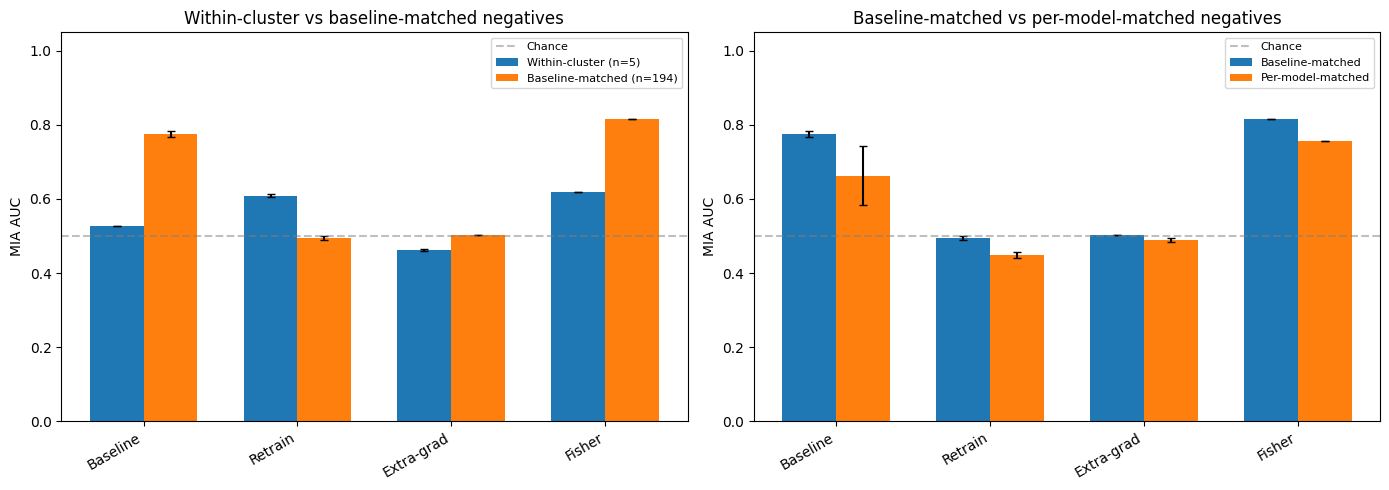

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

method_names = list(models.keys())
x = np.arange(len(method_names))
width = 0.35

# Panel 1: Within-cluster vs baseline matched
ax = axes[0]
wc_aucs = [within_cluster_results[m]['mean_auc'] for m in method_names]
wc_stds = [within_cluster_results[m]['std_auc'] for m in method_names]
bm_aucs = [baseline_matched_results[m]['mean_auc'] for m in method_names]
bm_stds = [baseline_matched_results[m]['std_auc'] for m in method_names]

ax.bar(x - width/2, wc_aucs, width, yerr=wc_stds, label='Within-cluster (n=5)', capsize=3)
ax.bar(x + width/2, bm_aucs, width, yerr=bm_stds, label=f'Baseline-matched (n={len(baseline_matched_idx)})', capsize=3)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Chance')
ax.set_xticks(x)
ax.set_xticklabels(method_names, rotation=30, ha='right')
ax.set_ylabel('MIA AUC')
ax.set_title('Within-cluster vs baseline-matched negatives')
ax.legend(fontsize=8)
ax.set_ylim([0.0, 1.05])

# Panel 2: Baseline-matched vs per-model-matched
ax = axes[1]
pm_aucs = [per_model_results[m]['mean_auc'] for m in method_names]
pm_stds = [per_model_results[m]['std_auc'] for m in method_names]

ax.bar(x - width/2, bm_aucs, width, yerr=bm_stds, label='Baseline-matched', capsize=3)
ax.bar(x + width/2, pm_aucs, width, yerr=pm_stds, label='Per-model-matched', capsize=3)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Chance')
ax.set_xticks(x)
ax.set_xticklabels(method_names, rotation=30, ha='right')
ax.set_ylabel('MIA AUC')
ax.set_title('Baseline-matched vs per-model-matched negatives')
ax.legend(fontsize=8)
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('../figures/matched_negative_validation.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Findings

The baseline matched negatives are 98.5% non-megakaryocyte (3 of 194 from cluster 13). The k-NN matching finds cells that are close in latent space but mostly from different cell types, because cluster 13 has only 5 cells in the unseen set.

Within-cluster evaluation (30 forget vs 5 cluster-13 unseen) drops baseline advantage from 0.550 to 0.053. Most of what the attacker detects with mixed-cluster negatives is biology, not training membership. With only 5 negatives, this comparison has limited statistical power, but the direction is clear.

Retrain within-cluster AUC is 0.609 (advantage 0.219), higher than its baseline-matched AUC of 0.495. Both groups (30 forget, 5 unseen) were excluded from retraining, so any signal above 0.5 reflects within-cluster heterogeneity or small-sample noise, not memorization.

Per-model matching reduces AUC for all methods (baseline -0.112, retrain -0.045, extra-grad -0.014, Fisher -0.058). Using the correct model's latent space for matching produces tighter negatives. Fisher's per-model mean distance is 0.053 (vs baseline 1.776), which fits the posterior collapse pattern where all inputs map to nearly the same latent point.

Extra-grad remains near chance with both matching strategies (0.503 baseline-matched, 0.489 per-model-matched), regardless of how negatives are selected.

The retrain floor of 0.481 (not 0.5) is at least partly a biology confound from cross-cluster matched negatives. Within-cluster matching would be preferable but requires larger rare clusters than PBMC cluster 13 provides.

In [11]:
# Save results
output = {
    'within_cluster': {
        'n_cluster13_unseen': len(c13_in_unseen),
        'results': within_cluster_results
    },
    'baseline_matched': {
        'n_matched': len(baseline_matched_idx),
        'results': baseline_matched_results
    },
    'per_model_matched': {
        'n_matched_per_model': {name: len(per_model_matched[name]) for name in models},
        'results': per_model_results
    }
}

with open(OUTPUTS_PATH / 'matched_negative_validation.json', 'w') as f:
    json.dump(output, f, indent=2)

print(f"Saved to {OUTPUTS_PATH / 'matched_negative_validation.json'}")

Saved to ../outputs/matched_negative_validation.json
